In [ ]:
def query_map_service(service_url, where='1=1', fields='*', crs=4326):
    # Define the query endpoint
    query_url = f"{service_url}/query"

# Determine the total number of records for the given where clause
count_params = {
        "where": where,
        "returnCountOnly": True,
        "f": "json"
    }
    tot_records_json = requests.get(query_url, params=count_params).json()
    tot_records = tot_records_json["count"]

    # Determine the step size for pages
    step_json = requests.get(service_url, params={'f': 'json'}).json()
    step = step_json["maxRecordCount"]

    # Define query parameters
    query_params = {
        "where": where,
        "outFields": ', '.join(fields) if isinstance(fields, list) else fields,
        "outSr": crs,
        "f": "geojson",
        "orderByFields": "OBJECTID",
        "returnGeometry": True,
        "resultRecordCount": step
    }

    # Loop through each page of query results concurrently
    with ThreadPoolExecutor(max_workers=4) as ex:
        futures = []
        for offset in range(0, tot_records, step):
            # Create each offset query
            query_params['resultOffset'] = offset
            offset_query = urllib.parse.urlencode(query_params)
            offset_query_url = f"{query_url}?{offset_query}"

            # Submit each query to the thread
            submit = ex.submit(gpd.read_file, offset_query_url)
            futures.append(submit)

        # Compile all futures once they're complete
        gdfs = [f.result() for f in as_completed(futures)]

    # Concatenate the resulting dataframes
    gdf = gpd.pd.concat(gdfs, ignore_index=True)

    return gdf

# NiN-data

## Basiskartlegging

Henter data fra basiskartlegging. For de som har KA som LKM, legg til fra LKM fila. For de andre så legg til fra tabellen 'Vern_ULKM'.

In [2]:
import geopandas

In [3]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import geopandas as gpd
import pandas as pd
import requests
import urllib.parse
import os

def query_map_service(service_url, where='1=1', fields='*', crs=4326, max_results=None):
    # Extract the layer/table index from the service URL
    index = service_url.split('/')[-1]

    # Get the service metadata
    service_metadata_url = service_url.rsplit('/', 1)[0] + '?f=pjson'
    service_metadata = requests.get(service_metadata_url).json()

    # Determine if the resource is a layer or a table
    resource_type = None
    for layer in service_metadata.get('layers', []):
        if str(layer['id']) == index:
            resource_type = 'layer'
            break
    for table in service_metadata.get('tables', []):
        if str(table['id']) == index:
            resource_type = 'table'
            break
    print(f"You're querying a {resource_type}.")

    if resource_type is None:
        raise ValueError("The specified resource index does not exist in the service metadata.")

    # Define the query endpoint
    query_url = f"{service_url}/query"

    # Determine the total number of records for the given where clause
    count_params = {
        "where": where,
        "returnCountOnly": True,
        "f": "json"
    }
    tot_records_json = requests.get(query_url, params=count_params).json()
    if 'count' not in tot_records_json:
        raise ValueError("The response does not contain the 'count' key. Please check the service URL and parameters.")
    tot_records = tot_records_json["count"]

    # Determine the step size for pages
    step_json = requests.get(service_url, params={'f': 'json'}).json()
    step = step_json.get("maxRecordCount", 1000)  # Default to 1000 if not provided

    # Adjust total records if max_results is specified
    if max_results is not None:
        tot_records = min(tot_records, max_results)

    # Define query parameters
    query_params = {
        "where": where,
        "outFields": ', '.join(fields) if isinstance(fields, list) else fields,
        "outSr": crs,
        "f": "geojson" if resource_type == 'layer' else "json",
        "orderByFields": "OBJECTID",
        "returnGeometry": resource_type == 'layer',
        "resultRecordCount": step
    }

    # Get the number of CPU cores available
    num_cores = os.cpu_count()
    print(f"Number of CPU cores available: {num_cores}")

    # Loop through each page of query results concurrently
    with ThreadPoolExecutor(max_workers=num_cores) as ex:
        futures = []
        for offset in range(0, tot_records, step):
            # Create each offset query
            query_params['resultOffset'] = offset
            offset_query = urllib.parse.urlencode(query_params)
            offset_query_url = f"{query_url}?{offset_query}"

            # Submit each query to the thread
            submit = ex.submit(requests.get, offset_query_url)
            futures.append(submit)

        # Compile all futures once they're complete
        responses = [f.result().json() for f in as_completed(futures)]

    # Check if the response contains geometry
    if resource_type == 'layer':
        # Concatenate the resulting GeoDataFrames
        gdfs = [gpd.GeoDataFrame.from_features(response['features']) for response in responses if 'features' in response]
        gdf = gpd.pd.concat(gdfs, ignore_index=True)
        return gdf
    else:
        # Concatenate the resulting DataFrames
        dfs = []
        for response in responses:
            if 'features' in response:
                records = [feature['attributes'] for feature in response['features']]
                dfs.append(pd.DataFrame(records))
        df = pd.concat(dfs, ignore_index=True)
        return df


In [4]:
VOnin_p = "https://kart.miljodirektoratet.no/arcgis/rest/services/vern_naturomrader_nin/MapServer/0"
NiN_gdf = query_map_service(VOnin_p)

You're querying a layer.
Number of CPU cores available: 96


In [5]:
VO_ULKM_p = "https://kart.miljodirektoratet.no/arcgis/rest/services/vern_naturomrader_nin/MapServer/12"
tbl_ulkm = query_map_service(VO_ULKM_p)

You're querying a table.
Number of CPU cores available: 96


In [8]:
tbl_ulk_raw = tbl_ulkm.copy()

Ser at det er noen feil i tabellen. Ser for Kartleggingsenhet5kid:NIN5K2210100382-NT2 av Ulkmkode:t33-KA_1, at dette er en semi-naturlig eng, men Kartleggingsenhet5kid:NIN5K2210100382-NT2 er knyttet til naturtypen T6 - strandberg.

In [9]:
#tbl_ulkm[['Kartleggingsenhet5kid','Ninhovedtypegruppe','Ninhovedtype']]
tmp = NiN_gdf[['Kartleggingsenhet5kid','Hovedtypegruppe','Hovedtype']]
tmp["Hovedtype"] = tmp["Hovedtype"].astype(str).str.replace(".0","")

tbl_ulkm["Ninhovedtype"] = tbl_ulkm["Ninhovedtype"].astype(str)
tbl_ulkm["Ninhovedtypegruppe"] = tbl_ulkm["Ninhovedtypegruppe"].astype(str)

#tmp.rename(columns={"Hovedtypegruppe":"Ninhovedtypegruppe","Hovedtype":"Ninhovedtype"},inplace=True)
tmp2 = tbl_ulkm.merge(tmp, on="Kartleggingsenhet5kid", how="left")
tmp3 = tmp2[(tmp2["Ninhovedtype"]!=tmp2["Hovedtype"])|(tmp2["Ninhovedtypegruppe"]!=tmp2["Hovedtypegruppe"])][["Kartleggingsenhet5kid","Ninhovedtype","Hovedtype","Ninhovedtypegruppe","Hovedtypegruppe","Ulkmkode"]]
# midx gir så en oversikt over hvilke kartleggingsenheter hvor den oppgitte hovedtypen ikke matcher med kartlagt figur
midx = tmp3["Kartleggingsenhet5kid"]
# fjerne de radene som representerer uLKM-egenskaper som ikke matcher med NIN-figurer
tbl_ulkm2 = tbl_ulkm[~tbl_ulkm['Kartleggingsenhet5kid'].isin(midx)]

C:\Users\endofs\AppData\Local\Temp\ipykernel_9152\3845026551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["Hovedtype"] = tmp["Hovedtype"].astype(str).str.replace(".0","")


In [10]:
NiN_gdf = NiN_gdf[~NiN_gdf["Kartleggingsenhet5kid"].isin(midx)]

In [11]:
# Forenkler og maserer tabellen
tbl_ulkm = tbl_ulkm[['Kartleggingsenhet5kid','Gradientkode','Trinndefinisjon']]
print(tbl_ulkm.head())
tbl_ulkm['Trinndefinisjon'] = tbl_ulkm['Trinndefinisjon'].str.replace('-','').str.replace(',','').str.replace(' ','')
print(tbl_ulkm.head())
tbl_ulkm['Trinndefinisjon'] = tbl_ulkm.apply(lambda row: row['Trinndefinisjon'].replace(row['Gradientkode'], ''), axis=1)
print(tbl_ulkm.head())
tbl_ulkm['uLKM'] = tbl_ulkm.groupby('Kartleggingsenhet5kid')['Gradientkode'].transform(lambda x: ', '.join(x))
print(tbl_ulkm.head())
t1 = tbl_ulkm[['Kartleggingsenhet5kid','Gradientkode','Trinndefinisjon','uLKM']].drop_duplicates()
print(t1.head())
t2 = t1.groupby(['Kartleggingsenhet5kid','uLKM','Gradientkode']).nunique('Trinndefinisjon').reset_index().sort_values('Trinndefinisjon', ascending=False)
print(t2.head())
# Må fjere de som har flere verdier per LKM
didx = t2[t2['Trinndefinisjon']>1]['Kartleggingsenhet5kid'].unique()
t1 = t1[~t1['Kartleggingsenhet5kid'].isin(didx)]
tbl_ulkm = t1[['Kartleggingsenhet5kid','uLKM','Gradientkode','Trinndefinisjon']]
tbl_ulkm["Kilde"]="uLKM-observert"

# Rename the columns
tbl_ulkm = tbl_ulkm.rename(columns={'Gradientkode': 'LKM',
                        'Trinndefinisjon': 'LKM_trinn',})

  Kartleggingsenhet5kid Gradientkode                Trinndefinisjon
0         NIN5014801-01           SS                           SS-+
1         NIN5014796-02           BK                           BK-0
2         NIN5014801-01           UE  UE-b,UE-c,UE-d,UE-e,UE-f,UE-g
3         NIN5014809-01           VM                     VM-0, VM-a
4         NIN5014800-01           VM                     VM-0, VM-a
  Kartleggingsenhet5kid Gradientkode     Trinndefinisjon
0         NIN5014801-01           SS                 SS+
1         NIN5014796-02           BK                 BK0
2         NIN5014801-01           UE  UEbUEcUEdUEeUEfUEg
3         NIN5014809-01           VM              VM0VMa
4         NIN5014800-01           VM              VM0VMa
  Kartleggingsenhet5kid Gradientkode Trinndefinisjon
0         NIN5014801-01           SS               +
1         NIN5014796-02           BK               0
2         NIN5014801-01           UE          bcdefg
3         NIN5014809-01           VM  

C:\Users\endofs\AppData\Local\Temp\ipykernel_9152\740331102.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl_ulkm["Kilde"]="uLKM-observert"


In [13]:
Enheter = pd.read_csv("NiN2_KartleggingsEnheter_skala.csv", sep = ";")
LKM = Enheter['Basistrinn_csv']

# Function to split the "LKM" column into separate columns
def split_lkm_column(df):
    # Split the "LKM" column by ", " to get individual key-value pairs
    lkm_split = df.str.split(', ', expand=True)
    
    # Split each key-value pair by "-" and create a dictionary for each row
    lkm_dicts = lkm_split.applymap(lambda x: dict([x.split('-')]) if pd.notna(x) else {})
    
    # Combine the dictionaries into a single dictionary for each row
    combined_dicts = lkm_dicts.apply(lambda row: {k: v for d in row for k, v in d.items()}, axis=1)
    
    # Convert the list of dictionaries to a DataFrame
    lkm_df = pd.DataFrame(combined_dicts.tolist())
    
    # Concatenate the original DataFrame with the new DataFrame
    result_df = pd.concat([df, lkm_df], axis=1)
    
    return result_df

# Apply the function to the DataFrame
result_df = split_lkm_column(Enheter['Basistrinn_csv'])

# Assuming result_df and Enheter are your DataFrames
result_df['Kartleggingsenhetkode'] = "NA_" + Enheter["1:5000"].str.split(" ", expand=True)[0]

# Move the 'Kartleggingsenhetkode' column to the start of the DataFrame
cols = ['Kartleggingsenhetkode'] + [col for col in result_df.columns if col != 'Kartleggingsenhetkode']
result_df = result_df[cols]

K5 = result_df.drop_duplicates()
# Remove the "Basistrinn_csv" column
K5 = K5.drop(columns=["Basistrinn_csv"])

# Define a function to concatenate values with no separator
def concatenate_values(series):
    aa = series.dropna()
    aa = aa.unique()
    return ''.join(aa.astype(str))

def concatenate_unique_characters(series):
    # Drop NaN values
    aa = series.dropna()
    # Concatenate all values into a single string
    concatenated_string = ''.join(aa.astype(str))
    # Extract unique characters and join them
    unique_characters = ''.join(sorted(set(concatenated_string)))
    return unique_characters

# Group by "Kartleggingsenhetkode" and concatenate the remaining columns
K5 = K5.groupby("Kartleggingsenhetkode").agg(concatenate_unique_characters).reset_index()
K5[['Kartleggingsenhetkode','KA', 'UF']]
#K5.to_csv("c:/data/kalkkart/NiN2_5K_LKM.csv", index = False, sep = ";", header=True)

,Kartleggingsenhetkode,KA,UF
0,NA_T1-C-1,ab,
1,NA_T1-C-10,efghi,
2,NA_T1-C-11,abcd,
3,NA_T1-C-12,efghi,
4,NA_T1-C-2,ab,
...,...,...,...
225,NA_V8-C-2,fgh,
226,NA_V8-C-3,fgh,
227,NA_V9-C-1,bcd,
228,NA_V9-C-2,ef,


In [14]:
NiN_gdf3 = NiN_gdf[['Kartleggingsenhet5kid','Kartleggingsenhetkode','geometry']].merge(K5, on=['Kartleggingsenhetkode'], how='left')
# Melt the DataFrame
melted_df = pd.melt(NiN_gdf3.drop(columns = ['Kartleggingsenhetkode','geometry']), id_vars=['Kartleggingsenhet5kid'], var_name='LKM', value_name='LKM_trinn')
melted_df["Kilde"] = "LKM-avledet"

In [15]:
# stack the two data frames
LKMs = pd.concat([melted_df[['Kartleggingsenhet5kid','Kilde','LKM','LKM_trinn']],
           tbl_ulkm[['Kartleggingsenhet5kid','Kilde','uLKM','LKM','LKM_trinn']]])
LKMs["LKM"] = LKMs["LKM"].str.upper()
LKMs = LKMs.drop_duplicates()# skjer noe dobbelbøkføring her
LKMs = LKMs[~LKMs["LKM_trinn"].isnull()]
LKMs = LKMs[LKMs["LKM_trinn"]!='']
LKMs = LKMs[~LKMs["Kartleggingsenhet5kid"].isin(midx)]

In [19]:
#idx = "NIN5013202-01"
#idx in midx
#print(melted_df[(melted_df["Kartleggingsenhet5kid"]==idx)] & (melted_df["LKM"]=="HI"))
#print(tbl_ulkm[(tbl_ulkm["Kartleggingsenhet5kid"]==idx) & (tbl_ulkm["LKM"]=="HI")])
#print(LKMs[(LKMs["Kartleggingsenhet5kid"]==idx)])

#print(melted_df[(melted_df["Kartleggingsenhet5kid"]==idx) & (melted_df["LKM"]=="KA")])

#tbl_ulkm[(tbl_ulkm["Kartleggingsenhet5kid"]==idx) & (tbl_ulkm["LKM"]=="HI")]


#tbl_ulkm[tbl_ulkm["Kartleggingsenhet5kid"]=="NIN5K2310173278-NT1"]
#NiN_gdf[NiN_gdf["Kartleggingsenhet5kid"]=="NIN5K2310173278-NT1"]
#LKMs[(LKMs["Kartleggingsenhet5kid"]=="NIN5K2310173278-NT1") & (LKMs["LKM"]=="HI")]


In [20]:
# sorter etter kartleggingsenhet5kid og LKM og kilde, og velg den siste per id og lkm, slik at man får en unik verdi per kartleggingsenhet5kid og LKM og den velger fortrinnsvis uLKM hvor dette er eksplisitt oppgitt. 
LKMs = LKMs.sort_values(['Kartleggingsenhet5kid','LKM','Kilde']).drop_duplicates(subset=['Kartleggingsenhet5kid','LKM'], keep='last')
#LKMs[LKMs["Kartleggingsenhet5kid"].str.contains(idx)]

Gi beskjed til Stig om at tabellnavnet "ULKM" blir misvisende, da tabellen også inklderer andre typer LKM'er slik som dLKM. 

In [22]:
# Pivot the DataFrame
LKMs_flat = LKMs.pivot(index=['Kartleggingsenhet5kid', 'uLKM'], columns='LKM', values='LKM_trinn').reset_index()
LKMs_flat_gdf = NiN_gdf[['Kartleggingsenhet5kid','Kartlagtdato','geometry']].merge(LKMs_flat, on=['Kartleggingsenhet5kid'], how='left')
print(LKMs_flat_gdf.head())
#LKMs_flat_gdf.to_file("C:/data/kalkkart/basiskartlegging_LKM_flat.gpkg", driver="GPKG")  
LKMs_flat_gdf.to_csv("basiskartlegging_LKM_flat.csv", index = False, sep = ";", header=True)


  Kartleggingsenhet5kid  Kartlagtdato  \
0         NIN0121546-01  1.353542e+12   
1         NIN0135513-03           NaN   
2   NIN5K2410213051-NT1  1.725799e+12   
3   NIN5K2310161459-NT3  1.687241e+12   
4         NIN6019773-02  1.504208e+12   

                                            geometry uLKM   BK   ER   FR   GS  \
0  POLYGON ((13.97825 67.27432, 13.97835 67.27431...  NaN  NaN  NaN  NaN  NaN   
1  POLYGON ((6.48257 62.74468, 6.48284 62.74469, ...  NaN  NaN  NaN  NaN  NaN   
2  POLYGON ((15.52688 66.7389, 15.52729 66.73899,...  NaN  NaN  NaN  NaN  NaN   
3  POLYGON ((10.48492 59.15737, 10.48498 59.15739...  NaN  NaN  NaN  NaN  NaN   
4  POLYGON ((17.55968 69.19313, 17.55991 69.19313...  NaN  NaN  NaN  NaN  NaN   

    HF   HI  ...   SV   TE         TV   UE   UF   VF   VI   VM   VS   VT  
0  NaN  NaN  ...  NaN  NaN        NaN  NaN   ab  NaN  NaN  NaN  NaN  NaN  
1  NaN  NaN  ...  NaN  NaN       cdef  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2  NaN  NaN  ...  NaN  NaN  cdefghijk  Na

In [23]:
LKMs_flat[LKMs_flat["Kartleggingsenhet5kid"].str.contains("NIN5K2110021531")]

LKM,Kartleggingsenhet5kid,uLKM,BK,ER,FR,GS,HF,HI,HR,IF,...,SV,TE,TV,UE,UF,VF,VI,VM,VS,VT
111628,NIN5K2110021531-NT1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,def,NaN,NaN,NaN,NaN,NaN
111629,NIN5K2110021531-NT2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1ijk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111630,NIN5K2110021531-NT3,NaN,NaN,NaN,NaN,NaN,+0ab,NaN,NaN,NaN,...,NaN,NaN,NaN,efg,NaN,NaN,NaN,NaN,NaN,NaN


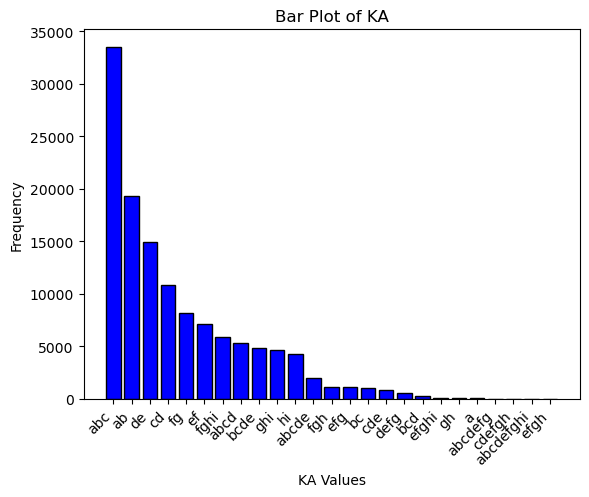

In [70]:
len(LKMs_flat_gdf)
import matplotlib.pyplot as plt

# Count occurrences of each unique value in the "KA" column
ka_counts = LKMs_flat_gdf["KA"].value_counts()

# Create a bar plot
plt.bar(ka_counts.index, ka_counts.values, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel("KA Values")
plt.ylabel("Frequency")
plt.title("Bar Plot of KA")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align them to the right

# Show the plot
plt.show()

In [24]:
LKMs_flat_gdf[LKMs_flat_gdf["KA"]=="bcde"]

,Kartleggingsenhet5kid,Kartlagtdato,geometry,uLKM,BK,ER,FR,GS,HF,HI,...,SV,TE,TV,UE,UF,VF,VI,VM,VS,VT
22,NIN0080954-01,1.422450e+12,"POLYGON ((6.46872 62.77236, 6.46885 62.77231, ...",NaN,NaN,NaN,NaN,NaN,+0ab,NaN,...,NaN,NaN,ijk,NaN,NaN,0abcdefgh¤,NaN,NaN,NaN,NaN
55,NIN5011827-01,1.470836e+12,"POLYGON ((10.94523 59.03046, 10.94525 59.03047...",NaN,NaN,NaN,NaN,NaN,+0ab,NaN,...,NaN,NaN,ijk,NaN,NaN,0abcdefgh¤,NaN,NaN,NaN,NaN
71,NIN5023509-01,1.474558e+12,"POLYGON ((10.40466 59.86853, 10.40496 59.8686,...","KA, UF",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,cde,NaN,NaN,NaN,NaN,NaN
147,NIN0035225-01,1.422450e+12,"POLYGON ((30.33868 70.31559, 30.33916 70.316, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156,NIN5K2310156672-NT2,1.684992e+12,"POLYGON ((10.48255 59.16129, 10.48263 59.16138...",NaN,NaN,NaN,NaN,NaN,+0ab,NaN,...,NaN,NaN,ijk,NaN,NaN,0abcdefgh¤,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225198,NIN0133241-01,1.344038e+12,"POLYGON ((15.45608 69.01123, 15.45594 69.01133...",NaN,NaN,NaN,NaN,NaN,+0ab,NaN,...,NaN,NaN,ijk,NaN,NaN,0abcdefgh¤,NaN,NaN,NaN,NaN
225263,NIN0122289-03,1.403482e+12,"POLYGON ((7.95569 63.45171, 7.95571 63.4517, 7...",NaN,NaN,NaN,NaN,NaN,+0ab,NaN,...,NaN,NaN,ijk,NaN,NaN,0abcdefgh¤,NaN,NaN,NaN,NaN
225370,NIN0027215-01,1.422450e+12,"POLYGON ((12.80614 67.84194, 12.8063 67.84188,...",NaN,NaN,NaN,NaN,NaN,+0ab,NaN,...,NaN,NaN,ijk,NaN,NaN,0abcdefgh¤,NaN,NaN,NaN,NaN
225378,NIN6026440-01,1.505817e+12,"POLYGON ((7.3511 61.72391, 7.35113 61.72392, 7...","HI, KA, SA",NaN,NaN,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
LKMs_flat_gdf.set_crs(epsg=4326, inplace=True)
LKMs_flat_gdf.to_file("basiskartlegging_LKM_flat.gpkg", driver="GPKG")

# Indikatorarter for kalk

Samler litt bakgrunnsinformasjon knyttet til sammenheng mellom grunnslagsdata og NiN-data.

In [2]:
import geopandas as gpd
#import pyogrio
import fiona
import rasterio as rio
import numpy as np 
# import pyarrow
# pyarrow fungerer ikke i min conda env
import os
import openpyxl
import pandas as pd

In [29]:

arter = pd.read_excel("Artsliste_Naturtyper_fra_ADB_20220629_vers2.xlsx", sheet_name="Artslister_NiN")
# Fjern de som mangler kategori
arter = arter[~arter["Kategori"].isna()]
# Behold de som er relevant mtp kalkgradienten
arter = arter[arter["Kategori"].str.contains("KA")]
# Behold den som er kjennetegnede for skille
arter = arter[arter["Kategori"].str.contains("s")]
# Function to find "KA" and extract the part 2-4 positions behind it
def extract_behind_ka(s, find = "KA", pos1=3, pos2=6):
    kid = s.find(find)
    return s[(kid+pos1):(kid+pos2)]
    #else:
    #    return None
# Apply the function to the 'Kategori' column
arter['KA_Skille'] = arter['Kategori'].apply(extract_behind_ka, find = "KA", pos1 = 3, pos2 = 6)
arter['KA_Skillestyrke'] = arter['Kategori'].apply(extract_behind_ka, find = "KA", pos1 = -3, pos2 = -1)
arter['KA_Skilletrinn']=arter['KA_Skille'].apply(lambda x: x[0])
#arter[['Populærnavn', "VitNavn","KE","KE_kode",  "KA_Trinn", "KA_Styrke"]].drop_duplicates()

arter[['Populærnavn', "VitNavn",'KA_Skille',  "KA_Skilletrinn", "KA_Skillestyrke"]].drop_duplicates()
# Fjern det som ikke er på artsnivå
arter = arter[arter["VitNavn"].apply(lambda x: " " in x)]
# Remove special characters from KA_Skille column
arter['KA_Skille'] = arter['KA_Skille'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)

In [32]:
#kalkfattig: cb, bc
#kalkrik: gh, hi
#intermediær: d-f

# Use groupby and sample to get one row per group
## utvalg = arter.groupby('KA_Skillestyrke').apply(lambda x: x.sample(n=1)).reset_index(drop=True)["VitNavn"]

arter['Nivå'] = np.where(
    (arter['KA_Skille'].str.contains("g|h|i")) & (~arter['KA_Skillestyrke'].str.contains("a|b|c|d|e|f")), 
    'Kalkrik', 
    np.where(
    (arter['KA_Skille'].str.contains("a|b|c")) & (~arter['KA_Skillestyrke'].str.contains("d|e|f")), 
    'Kalkfattig', 
    np.where(
    (arter['KA_Skille'].str.contains("d|e|f")) & (~arter['KA_Skillestyrke'].str.contains("c|f")), 
    'Intermediær', 
    'Uklar')))
arter[['Populærnavn', "VitNavn", "HovedType","Nivå",'KA_Skille', "KA_Skillestyrke"]].drop_duplicates()
arter['Nivå_hovedtype_art_n'] = arter.groupby(['Populærnavn', 'HovedType'])['Nivå'].transform('nunique')
arter['Nivå_art_n'] = arter.groupby(['Populærnavn'])['Nivå'].transform('nunique')
arter['Skille_art_n'] = arter.groupby(['Populærnavn'])['KA_Skille'].transform('nunique')
arter['Skille_hovedtyper'] = arter.groupby('Populærnavn')['HovedType'].transform(lambda x: ', '.join(x.unique()))

# Filtrere til de som bare har én(1) betydning på tvers av hovedtyper, og velger en rad per art
utvalg = arter[arter['Skille_art_n']==1].groupby(['Populærnavn', 'HovedType']).first().reset_index()[['Populærnavn', "VitNavn", "HovedType","Nivå","Skille_art_n","Skille_hovedtyper",'KA_Skille','KA_Skilletrinn', "KA_Skillestyrke"]]
# Da sitter vi igjen med de som har en klar betydning på tvers av hovedtyper, og kan velge en rad per art
print(len(utvalg))
len(arter)

505


2202

In [33]:
utvalg[~utvalg["KA_Skillestyrke"].str.contains("-")].to_csv("kalkarter_utvalg.csv", sep = ";")
utvalg[~utvalg["KA_Skillestyrke"].str.contains("-")]

,Populærnavn,VitNavn,HovedType,Nivå,Skille_art_n,Skille_hovedtyper,KA_Skille,KA_Skilletrinn,KA_Skillestyrke
0,Aksveronika,Veronica spicata,T2,Kalkrik,1,T2,hg,h,s*
1,Anema nummularium,Anema nummularium,T1,Kalkrik,1,T1,gf,g,s*
2,Arve,Cerastium fontanum,T32,Kalkfattig,1,T32,dc,d,s*
3,Athyrium filix-femina,Athyrium filix-femina,T15,Kalkfattig,1,"V8, T15",dc,d,s+
4,Athyrium filix-femina,Athyrium filix-femina,V8,Kalkfattig,1,"V8, T15",dc,d,s*
...,...,...,...,...,...,...,...,...,...
497,Vifteglye,Callome multipartita,T1,Kalkrik,1,T1,gf,g,s*
499,Vritorvmose,Sphagnum contortum,V1,Intermediær,1,V1,ed,e,s*
501,Vårmure,Potentilla tabernaemontani,T2,Intermediær,1,T2,fe,f,s+
502,Vårrublom,Draba verna,T2,Uklar,1,T2,fe,f,"f,"


In [34]:
# Hvor mange har ulike skilletrinn på tvers av hovedtyper?
utvalg.groupby(['Populærnavn'])['KA_Skille'].nunique().reset_index()

,Populærnavn,KA_Skille
0,Aksveronika,1
1,Anema nummularium,1
2,Arve,1
3,Athyrium filix-femina,1
4,Bakkefiol,1
...,...,...
373,Vårkål,1
374,Vårmure,1
375,Vårrublom,1
376,Vårstarr,1


## Artskart

In [35]:
nortaxa = pd.read_csv("https://nortaxa.artsdatabanken.no/api/v1/DataTransfer/Export?scientificNameId=1131&includeSynonyms=true&includeVernacularNames=true&exportType=Csv", sep = ";")

C:\Users\endofs\AppData\Local\Temp\ipykernel_9152\760625935.py:1: DtypeWarning: Columns (3,7,8,34) have mixed types. Specify dtype option on import or set low_memory=False.
  nortaxa = pd.read_csv("https://nortaxa.artsdatabanken.no/api/v1/DataTransfer/Export?scientificNameId=1131&includeSynonyms=true&includeVernacularNames=true&exportType=Csv", sep = ";")


In [36]:
# Merge the dataframes on the matching 'Populærnavn' and 'VernacularNameBokmaal'
utvalg['Populærnavn'] = utvalg['Populærnavn'].str.lower()
merged_df = pd.merge(utvalg, nortaxa, left_on='Populærnavn', right_on='VernacularNameBokmaal', how='left')
nortaxa["AcceptedScientificNameId"] = nortaxa["AcceptedScientificNameId"].astype(int)
# Extract the 'AcceptedScientificNameId' and 'Populærnavn'
result = merged_df[['Populærnavn', 'AcceptedScientificNameId']].drop_duplicates()
merged_df = merged_df[~merged_df['AcceptedScientificNameId'].isna()]
merged_df['AcceptedScientificNameId'] = merged_df['AcceptedScientificNameId'].astype(int)
merged_df['AcceptedScientificNameId'] = merged_df['AcceptedScientificNameId'].astype(str)

In [37]:
display(merged_df)

,Populærnavn,VitNavn,HovedType,Nivå,Skille_art_n,Skille_hovedtyper,KA_Skille,KA_Skilletrinn,KA_Skillestyrke,VernacularNameBokmaal,...,PresentationName,Rank,TaxonomicStatus,NomenclaturalStatuses,NameString,Author,Reference,ValidFrom,Comment,ExistsInNorway
0,aksveronika,Veronica spicata,T2,Kalkrik,1,T2,hg,h,s*,aksveronika,...,Pseudolysimachium spicatum,Species,Synonym,NaN,spicatum,(L.) Opiz,NaN,13.04.2018,NaN,True
1,aksveronika,Veronica spicata,T2,Kalkrik,1,T2,hg,h,s*,aksveronika,...,Pseudolysimachion spicatum,Species,Synonym,NaN,spicatum,(L.) Opiz,NaN,13.04.2018,NaN,True
2,aksveronika,Veronica spicata,T2,Kalkrik,1,T2,hg,h,s*,aksveronika,...,Veronica spicata,Species,Accepted,NaN,spicata,L.,NaN,13.04.2018,NaN,True
4,arve,Cerastium fontanum,T32,Kalkfattig,1,T32,dc,d,s*,arve,...,Cerastium fontanum,Species,Accepted,NaN,fontanum,Baumg.,NaN,20.08.2009,NaN,True
7,bakkefiol,Viola collina,T2,Kalkrik,1,"T2, T32, T4",hg,h,s-,bakkefiol,...,Viola collina,Species,Accepted,NaN,collina,Besser,NaN,20.08.2009,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2098,vårstarr,Carex caryophyllea,T2,Kalkrik,1,T2,hg,h,s*,vårstarr,...,Carex praecox,Species,Synonym,NaN,praecox,Jacq. non Schreb.,NaN,25.06.2016,NaN,True
2099,vårstarr,Carex caryophyllea,T2,Kalkrik,1,T2,hg,h,s*,vårstarr,...,Carex verna,Species,Synonym,NaN,verna,Chaix,NaN,25.06.2016,NaN,True
2100,vårveronika,Veronica verna,T32,Kalkrik,1,T32,hg,h,s-,vårveronika,...,Veronica verna,Species,Accepted,NaN,verna,L.,NaN,28.06.2016,NaN,True
2101,vårveronika,Veronica verna,T32,Kalkrik,1,T32,hg,h,s-,vårveronika,...,Veronica brevistyla,Species,Synonym,NaN,brevistyla,Moris,NaN,28.06.2016,NaN,True


In [71]:
import os
import time
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import requests
from requests.exceptions import ConnectionError, Timeout
import psutil

from threading import Lock

# Create a global lock
file_lock = Lock()

# Base URL for the Artskart API
base_url = "https://artskart.artsdatabanken.no/publicapi/api/observations/list"
# Base parameters for the API request
base_params = ['filter.precision=0', 'filter.precision=1', 'filter.precision=2']
# Years to query
years = range(2000, 2025)
# List of species to query
species = result[~result["AcceptedScientificNameId"].isna()]["AcceptedScientificNameId"].astype(int).astype(str).to_list()#["99856"]  # Example species IDs
output_file = 'ADB_kalkarter.csv'
log_file = 'ADB_kalkarter_log.csv'
maxCount = 100

def get_artskart_response(base_url, pageIndex, params, df, i, maxCount=maxCount):
    query = f"{base_url}?pageIndex={pageIndex}&pageSize={maxCount}&" + "&".join(params)
    #print(query)
    retries = 5
    for attempt in range(retries):
        try:
            response = requests.get(query)
            if response.status_code == 200:
                # Process the response and update df, endOfRecords, status
                data = response.json()
                if "Observations" in data:
                    new_df = pd.DataFrame(data["Observations"])
                else:
                    new_df = pd.DataFrame()
                df = pd.concat([df, new_df], ignore_index=True)
                endOfRecords = len(new_df) < maxCount
                status = response.status_code
                return df, endOfRecords, status
            else:
                response.raise_for_status()
        except (ConnectionError, Timeout) as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            time.sleep(2 ** attempt)  # Exponential backoff
    raise ConnectionError(f"Failed to get response after {retries} attempts")

def process_species_year(specie, year):
    df = pd.DataFrame()
    endOfRecords = False
    pageIndex = 1
    status = 200
    params1 = base_params + [f'filter.scientificNameIds={specie}']
    params = params1 + [f'filter.fromDate={year}-01-01', f'filter.toDate={year}-12-31']
    params_string = '&'.join(params)
    
    # Check if query already completed
    skip_query = False
    if os.path.exists(log_file):
        with open(log_file, 'r', encoding='utf-8') as f:
            if params_string in f.read():
                #print(params_string)
                print(f"Skipping {specie} in {year} - already processed")
                skip_query = True
    
    if not skip_query:
        while not endOfRecords and status == 200:
            df, endOfRecords, status = get_artskart_response(base_url, pageIndex, params, df, i=specie, maxCount=maxCount)
            #print(pageIndex)
            pageIndex += 1
        
        if not df.empty:
            with file_lock:
                mode = 'a' if os.path.exists(output_file) else 'w'
                header = not os.path.exists(output_file)

                # Write to CSV with UTF-8 encoding and handle potential errors
                try:
                    df.to_csv(output_file, mode=mode, header=header, index=False, encoding='utf-8')
                except Exception as e:
                    print(f"Error writing to CSV: {e}")
        
        with file_lock:
            with open(log_file, 'a', encoding='utf-8') as f:
                f.write(f"{params_string}\n")
        
        print(f"Data for {specie} in {year} has been collected.")
        time.sleep(5)
        
        # Reset the DataFrame for the next query
        df = pd.DataFrame()

# Parallel processing
with ThreadPoolExecutor(max_workers=psutil.cpu_count(logical=True) - 1) as executor:
    futures = []
    for specie in species:
        #print(specie)
        for year in years:
            futures.append(executor.submit(process_species_year, specie, year))
    
    for future in futures:
        future.result()  # Wait for all threads to complete

Data for 102575 in 2006 has been collected.
Data for 102575 in 2005 has been collected.
Data for 102575 in 2003 has been collected.
Data for 102575 in 2007 has been collected.
Data for 102575 in 2008 has been collected.
Data for 102575 in 2004 has been collected.
Data for 102575 in 2001 has been collected.
Data for 102575 in 2002 has been collected.
Data for 102575 in 2009 has been collected.
Data for 102575 in 2000 has been collected.
Data for 102575 in 2010 has been collected.
Data for 102575 in 2012 has been collected.
Data for 102575 in 2011 has been collected.
Data for 102575 in 2013 has been collected.
Data for 101469 in 2003 has been collected.
Data for 102796 in 2002 has been collected.
Data for 102796 in 2005 has been collected.
Data for 102575 in 2019 has been collected.
Data for 102796 in 2007 has been collected.
Data for 102796 in 2001 has been collected.
Data for 102575 in 2018 has been collected.
Data for 101469 in 2004 has been collected.
Data for 102796 in 2000 has been

In [16]:
output_file = 'ADB_kalkarter.csv'

# Redirect warnings to a file
log_file = 'kalkarter_warnings_log.txt'
with open(log_file, 'w') as f:
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        
        # Your code that might generate warnings
        try:
            kalkartsfunn = pd.read_csv(
                output_file,
                sep=',',
                quotechar='"',
                encoding='utf-8',
                encoding_errors='ignore',
                on_bad_lines='warn',
                low_memory=False
            )
        except pd.errors.ParserError as e:
            # Capture ParserError messages
            f.write(f"ParserError: {str(e)}\n")
        
        # Write warnings to the log file
        for warning in w:
            f.write(f"WARNING: {warning.message}\n")

In [77]:

kalkartsfunn = kalkartsfunn[~kalkartsfunn['ScientificNameId'].isna()]# = kalkartsfunn['ScientificNameId'].astype(int)
# Change the data type of 'ScientificNameId' to integer
kalkartsfunn['ScientificNameId'] = kalkartsfunn['ScientificNameId'].astype(int)
kalkartsfunn['ScientificNameId'] = kalkartsfunn['ScientificNameId'].astype(str)
kalkartsfunn['Longitude'] = kalkartsfunn['Longitude'].str.replace(",", ".").astype(float)
kalkartsfunn['Latitude'] = kalkartsfunn['Latitude'].str.replace(",", ".").astype(float)
kalkartsfunn = kalkartsfunn.merge(merged_df[merged_df["Skille_art_n"]==1], left_on = 'ScientificNameId', right_on = 'AcceptedScientificNameId')

In [101]:
samling = kalkartsfunn[['AcceptedScientificNameId', 'Longitude','Latitude','Collection']].groupby(['AcceptedScientificNameId','Latitude', 'Longitude']).agg({
    'Collection': lambda x: ', '.join(map(str, x.unique()))
}).reset_index()

ds = kalkartsfunn[['AcceptedScientificNameId', 'Longitude','Latitude','DatasetName']].groupby(['AcceptedScientificNameId','Latitude', 'Longitude']).agg({
    'DatasetName': lambda x: ', '.join(map(str, x.unique()))
}).reset_index()

# Now merge samling and ds
meta = samling.merge(ds, on=['AcceptedScientificNameId', 'Latitude', 'Longitude'], how='outer')
display(meta.head())

In [96]:
#samling
#kalkartsfunn[kalkartsfunn['Collection'].str.contains('nibio')]
# Configure pandas to display all columns
#pd.set_option('display.max_columns', None)
# display(kalkartsfunn[kalkartsfunn['Id'].str.contains('413d74ce-f8d1-4611-973f-7d1a23274a6e')])


,species,Id,Institution,InstitutionCode,InstitutionUrl,InstitutionLogoUrl,Collection,CollectionCode,CatalogNumber,DetailUrl,Collector,CollectedDate,IdentifiedBy,DatetimeIdentified,BasisOfRecord,TaxonId_x,Habitat,DatasetId,DatasetName,ObsUrl,Name,ScientificName,Author_x,kingdom,phylum,klass,order,family,genus,subspecies,specificEpithet,infraspecificEpithet,Status,TypeObj,Sex,Count,Notes,Country,County,CountyId,Municipality,MunicipalityId,Locality,Longitude,Latitude,Precision,FootprintWKT,East,North,Projection,Info,PropertyUrls,ThumbImgUrls,Behavior,OtherCatalogNumbers,TrackDateTime,ScientificNameId_x,Populærnavn,VitNavn,HovedType,Nivå,Skille_art_n,Skille_hovedtyper,KA_Skille,KA_Skilletrinn,KA_Skillestyrke,VernacularNameBokmaal,StatusBokmaal,ReferenceBokmaal,CommentBokmaal,ValidFromBokmaal,VernacularNameNynorsk,StatusNynorsk,ReferenceNynorsk,CommentNynorsk,ValidFromNynorsk,VernacularNameNordSamisk,StatusNordSamisk,ReferenceNordSamisk,CommentNordSamisk,ValidFromNordSamisk,Sphere,Kingdom,Subkingdom,Phylum,Subphylum,Superclass,Class,Subclass,Infraclass,Superorder,Order,Suborder,Infraorder,Superfamily,Family,Subfamily,Tribe,Genus,Subgenus,Section,Species,Subspecies,Variety,Form,TaxonId_y,ScientificNameId_y,ParentScientificNameId,AcceptedScientificNameId,PresentationName,Rank,TaxonomicStatus,NomenclaturalStatuses,NameString,Author_y,Reference,ValidFrom,Comment,ExistsInNorway
1619,fontanum,nibio/nibio/413d74ce-f8d1-4611-973f-7d1a23274a6e,Norsk institutt for bioøkonomi,NIBIO,NaN,NaN,nibio hos Norsk institutt for bioøkonomi,nibio,413d74ce-f8d1-4611-973f-7d1a23274a6e,NaN,Ragnhild Heimstad | Sølvi Wehn,18.08.2022,Ragnhild Heimstad | Sølvi Wehn,NaN,humanobservation,61429,NA_T32-C-20,NaN,Overvåkning av semi-naturlig eng,https://artskart.artsdatabanken.no/#featureInf...,arve,Cerastium fontanum,Baumg.,Plantae,Magnoliophyta,Eudicots,Caryophyllales,Caryophyllaceae,Cerastium,NaN,NaN,NaN,LC,NaN,NaN,< 1 % dekning,NaN,Norway,Vestland,46,Bremanger,4648,ASO_028_255_1_Buvika,4.8648,61.8027,50,POINT (-32734.83 6893885.19),-32734.83,6893885.19,32633,NaN,"[{'Type': 'Norsk Rødliste 2021', 'LinkTekst': ...",[],[],NaN,2022-12-22T06:57:46.0421922,101469,arve,Cerastium fontanum,T32,Kalkfattig,1,T32,dc,d,s*,arve,Preferred,NaN,NaN,13.09.2009,arve,Preferred,NaN,NaN,13.09.2009,NaN,NaN,NaN,NaN,NaN,Biota,Plantae,NaN,Magnoliophyta,NaN,NaN,Eudicots,NaN,NaN,NaN,Caryophyllales,NaN,NaN,NaN,Caryophyllaceae,NaN,NaN,Cerastium,NaN,NaN,fontanum,NaN,NaN,NaN,61429.0,101469.0,101456.0,101469,Cerastium fontanum,Species,Accepted,NaN,fontanum,Baumg.,NaN,20.08.2009,NaN,True


In [ ]:
tmp = kalkartsfunn[["AcceptedScientificNameId",'PresentationName',"VernacularNameBokmaal","Skille_hovedtyper", "KA_Skilletrinn", "KA_Skille","KA_Skillestyrke","Precision","CollectedDate",'DetailUrl', 'Longitude','Latitude']]
tmp = tmp.merge(meta, on=['AcceptedScientificNameId', 'Longitude', 'Latitude'], how='left')
display(tmp.head(10))
#print(f"Total : {len(tmp)}")
#print(f"Total original: {len(kalkartsfunn)}")

In [104]:
# Group by latitude, longitude, and the specified columns
#aggregated_df = tmp[["AcceptedScientificNameId",'PresentationName',"VernacularNameBokmaal","Skille_hovedtyper", "KA_Skilletrinn", "KA_Skille","KA_Skillestyrke","Precision","CollectedDate",'DetailUrl', 'Longitude','Latitude']].groupby(['AcceptedScientificNameId','Latitude', 'Longitude']).agg({
    #'VernacularNameBokmaal': lambda x: ', '.join(x.unique())
#}).reset_index()
#aggregated_df["Arter_n"]=aggregated_df["Arter"].str.count(",")+1
## Display the aggregated DataFrame
#print(aggregated_df.head())


    Latitude  Longitude Skille_hovedtyper KA_Skilletrinn KA_Skille  \
0  57.967250   7.549154      T32, T34, T7              c        cd   
1  57.967250   7.549154               T34              e        ef   
2  57.968113   7.496252               T34              e        ef   
3  57.968193   7.492204          T32, T15              d        dc   
4  57.968351   7.495821          T32, T15              d        dc   

  KA_Skillestyrke       Arter  Arter_n  
0              s-  finnskjegg        1  
1              s+  klokkelyng        1  
2              s*   bjørnekam        1  
3              s+      gulaks        1  
4              s+      gulaks        1  


In [ ]:
meta = samling.merge(ds, on=['AcceptedScientificNameId', 'Latitude', 'Longitude'], how='outer')

In [ ]:
import geopandas as gpd
kalkartsfunn.rename(columns={'AcceptedScientificNameId': 'ScientificNameId'}, inplace=True)
gdf = gpd.GeoDataFrame(kalkartsfunn[["ScientificNameId",'PresentationName',"VernacularNameBokmaal","Skille_hovedtyper", "KA_Skilletrinn", "KA_Skille","KA_Skillestyrke","Precision","CollectedDate",'DetailUrl','Collection','DatasetName','Overvåking','Profesjonell', 'Longitude','Latitude']],
                        geometry=gpd.points_from_xy(kalkartsfunn['Longitude'], kalkartsfunn['Latitude']))
gdf['ScientificNameId'] = gdf['ScientificNameId'].astype(int)
gdf['Longitude'] = gdf.geometry.x
gdf['Latitude'] = gdf.geometry.y
# write the GeoDataFrame to a GeoPackage
gdf.to_file("ADB_kalkartsfunn.gpkg", driver="GPKG")

# KOMMET HIT:   Eksporter til AGOL: Kart

In [24]:
# Read in geopackage file
gdf = gpd.read_file("ADB_kalkartsfunn.gpkg")
# Extract coordinates
#gdf['Longitude'] = gdf.geometry.x
#gdf['Latitude'] = gdf.geometry.y
#output_file = "c:/data/kalkkart/GBIF_kalkarter_rensket_beriket.csv"
#gdf.drop(columns='geometry').to_csv(output_file, sep=";")

In [8]:
# Read geographic information of the geoodataframe, such as the coordinate reference system (CRS)
print(gdf.crs)

None


In [1]:
import arcpy
from arcgis.gis import GIS
import shutil
import os
tCRS = 4326

In [26]:
def gdf_to_file_gdb_arcpy(gdf=None, csv=None, output_gdb=None, layer_name=None, crs = 4326):
    try:
        # Ensure the output directory exists
        os.makedirs(os.path.dirname(output_gdb), exist_ok=True)
        
        if csv is not None:
            #temp_csv = os.path.join(os.path.dirname(output_gdb), 'temp_data.csv')
            print("Handle a csv.-file")
            #gdf.to_csv(temp_csv, index=False)
        #else:
            temp_csv = csv
            # Read the CSV and convert WKT to geometry
            df = pd.read_csv(temp_csv)
            os.remove(temp_csv)
            df['geometry'] = df['geometry'].apply(wkt.loads)
            gdf = gpd.GeoDataFrame(df, geometry='geometry')
        
        print("Read temp file")
        
        # Extract coordinates
        if gdf is not None:
            gdf['Longitude'] = gdf.geometry.x
            gdf['Latitude'] = gdf.geometry.y
        
        # Write the updated DataFrame to a temporary CSV
        temp_csv_with_coords = os.path.join(os.path.dirname(output_gdb), 'temp_data_with_coords.csv')
        print("Write temp file with coordinates")
        gdf.drop(columns='geometry').to_csv(temp_csv_with_coords, index=False)
        
        # Create a File Geodatabase
        print("Create .gdb")
        if not arcpy.Exists(output_gdb):
            arcpy.CreateFileGDB_management(os.path.dirname(output_gdb), os.path.basename(output_gdb))
        
        # Convert the CSV to a table in the File Geodatabase
        print("Convert CSV to table in gdb")
        arcpy.TableToTable_conversion(temp_csv_with_coords, output_gdb, layer_name)
        
        # Define the spatial reference (assuming WGS 84, adjust as needed)
        spatial_ref = arcpy.SpatialReference(crs)
        
        print("Add data to gdb")
        # delete the existing feature class if it exists
        print(f"     Delete existing feature class if it exists: {layer_name}")
        layerName = os.path.join(output_gdb, layer_name + "_points")
        if arcpy.Exists(layerName):
            arcpy.Delete_management(layerName)
        # Convert the table to a feature class    
        print("     Convert table to feature class")
        arcpy.XYTableToPoint_management(
            os.path.join(output_gdb, layer_name),
            layerName,
            "Longitude", "Latitude",
            coordinate_system=spatial_ref
        )
        
        # Clean up the temporary CSV files
        #os.remove(temp_csv)
        os.remove(temp_csv_with_coords)
        print(f"Data successfully written to {layerName}")

    finally:
        # Clear any workspace cache to release locks
        arcpy.ClearWorkspaceCache_management()
        print("Workspace cache cleared to release locks.") 

In [4]:
# Get the path of the current notebook
notebook_path = os.path.abspath(".")
# Extract the folder containing the notebook
notebook_folder = os.path.dirname(notebook_path)

# Example usage
outputGdb = "ADB_kalkarter.gdb"
outputGdbPath = os.path.join(notebook_path, outputGdb)
LAYERNAME = 'Kalkarter'
outputFile = "ADB_kalkarter_rensket_beriket.csv"

import settings


In [12]:
import settings
gis = GIS(url=settings.agolUrl, username=settings.agolUser, password=settings.agolPwd, verify_cert=True)

In [28]:
# Assuming gdf is your GeoDataFrame
gdf_to_file_gdb_arcpy(gdf=gdf, output_gdb=outputGdbPath, layer_name=LAYERNAME)
# gdf_to_file_gdb_arcpy(csv="ADB_kalkarter.csv", output_gdb=outputGdbPath, layer_name=LAYERNAME)

Read temp file
Write temp file with coordinates
Create .gdb
Convert CSV to table in gdb
Add data to gdb
     Delete existing feature class if it exists: Kalkarter
     Convert table to feature class
Data successfully written to e:\temp\endre\kalkkart\ADB_kalkarter.gdb\Kalkarter_points
Workspace cache cleared to release locks.


In [59]:
from arcgis.map import Map
from arcgis.gis import GIS
# https://developers.arcgis.com/python/latest/api-reference/arcgis.map.toc.html


def upload_and_publish_fgdb(source=None, title=None, tags=None, description=None, snippet=None, 
                           overwrite_if_exists=None, folder_name=None, WebMap=False):
    """
    Upload and publish a file geodatabase to ArcGIS Online with existing item checking.
    
    Parameters:
    - output: Path to the file geodatabase
    - title: Title for the items
    - tags: Tags for the items
    - description: Description for the items
    - snippet: Snippet for the items
    - overwrite_if_exists: True to auto-delete, False to prompt, None to abort if exists
    - folder_name: Name of the folder to place items in (None for root folder)
    """
    
    # Kobler til AGOL
    print("Kobler til AGOL")
    gis = GIS(url=settings.agolUrl, username=settings.agolUser, password=settings.agolPwd, verify_cert=True)
    
    # Handle folder specification
    folder = None
    item_folder = None
    if folder_name:
        # Check if folder exists
        folders = gis.users.me.folders
        folder_exists = False
        for f in folders:
            if f['title'] == folder_name:
                folder = f['id']
                folder_exists = True
                print(f"Bruker eksisterende mappe: '{folder_name}'")
                break
        
        # Create folder if it doesn't exist
        if not folder_exists:
            print(f"Oppretter ny mappe: '{folder_name}'")
            new_folder = gis.content.create_folder(folder_name)
            folder = new_folder['id']
        
        # Get folder object for uploading
        item_folder = gis.content.folders.get(folder=folder_name)
    else:
        print("Plasserer elementer i rotmappen")
    
    # Check for existing items
    print("Sjekker for eksisterende elementer...")
    search_query = f'title:"{title}"'
    existing_items = gis.content.search(query=search_query, item_type='Feature Service')
    existing_webmaps = gis.content.search(query=search_query, item_type='Web Map')
    existing_files = gis.content.search(query=search_query, item_type='File Geodatabase')
    
    all_existing = existing_items + existing_webmaps + existing_files
    
    if all_existing:
        print(f"Fant {len(all_existing)} eksisterende element(er) med tittelen '{title}':")
        for item in all_existing:
            print(f"  - {item.title} ({item.type}) - ID: {item.id}")
        
        should_delete = False
        
        if overwrite_if_exists is True:
            should_delete = True
            print("Auto-sletter eksisterende elementer...")
        elif overwrite_if_exists is False:
            response = input("Vil du slette de eksisterende elementene? (y/n): ")
            should_delete = response.lower() in ['y', 'yes', 'ja', 'j']
        else:
            print("Avbryter opplasting siden elementer med samme navn allerede eksisterer.")
            return None
        
        if should_delete:
            for item in all_existing:
                try:
                    item.delete(permanent = True) # Må være permanent=True for å slette elementet helt, også fra papirkurven
                    print(f"Slettet: {item.title} ({item.type})")
                except Exception as e:
                    print(f"Feil ved sletting av {item.title}: {e}")
        else:
            print("Avbryter opplasting.")
            return None
    
    # Pakker sammen filgeodatabasen til en .zip-fil
    print(f"Pakker sammen filgeodatabasen til {source}.zip")
    shutil.make_archive(source, format='zip', root_dir=os.path.dirname(source), base_dir=os.path.basename(source))
    
    print("Prepper filen")
    item_properties = {
        'title': title,
        'tags': tags,
        'type': 'File Geodatabase',
        'description': description
    }
    
    # Upload the file
    print("Laster opp filen")
    if folder_name:
        fgdb_item = item_folder.add(item_properties, source + ".zip")
        fgdb_item = fgdb_item.result()  # Ensure we get the item object
        # print which type of item was uploaded
        print(f"        Lastet opp {fgdb_item.type} til mappen '{folder_name}'")
    else:
        fgdb_item = gis.content.add(item_properties, source + ".zip")
    
    # Publish the uploaded file geodatabase as a hosted feature layer
    print(f"Publiserer feature layer av typen: {fgdb_item.type} til mappen '{folder_name}'")
    published_layer = fgdb_item.publish()
    

    # If WebMap is True, create a web map
    if WebMap:
        # Create a new web map
        web_map = Map()

        # Add the hosted feature layer to the web map
        web_map.content.add(published_layer)

        # Define web map properties
        web_map_properties = {
            "title": title,
            "snippet": snippet,
            "tags": tags
        }

        # Add folder to web map properties if specified
        if folder:
            web_map_properties['folder'] = folder    

        # Save the web map
        web_map_item = web_map.save(web_map_properties)

        # Move web map to specified folder if needed
        if folder:
            try:
                web_map_item.move(folder)
                print(f"Flyttet Web Map til mappe: '{folder_name}'")
            except:
                pass
                
        # Share the web map
        web_map_item.share(everyone=True)

        print(f"Web map '{title}' has been created and shared.")
    if folder_name:
        print(f"Alle elementer er plassert i mappen: '{folder_name}'")
    
    return {
        'feature_service': published_layer,
        #'web_map': web_map_item,
        'file_geodatabase': fgdb_item,  # Now properly defined
        'folder': folder_name
    }

In [60]:

# Get the path of the current notebook
notebook_path = os.path.abspath(".")
# Extract the folder containing the notebook
notebook_folder = os.path.dirname(notebook_path)

SUMMARY = 'Observasjoner fra Artskart for arter som er angitt som skillearter for kalktrinn. Vi har utelatt de som er svake skillearter, og bare beholdt de artene som er konsekvent for et gitt skille for hovedtypen som helhet. For eksempel at arten er en skilleart for trinn d|e for skog som helhet, og ikke bare for skog på gitte trinn av uttørkningsfare. Vi har også begrenset oss til observasjoner etter 2000, og med presisjon bedre enn 100 meter. For arter som er skilleart på samme trinn for flere hovedtyper så har vi lagt til dette som tilleggsinfo direkte på punktlaget, ellers så må man se til den assosierte tabellen for å se an til hvilken hovedtypen den er skille for. '
TITLE = "Signalarter for kalkskiller"
TAGS = 'NiN, arter'
FOLDER_NAME = "kalkkart"  # Specify the folder name here

# Call with user prompt for existing items and folder specification
result = upload_and_publish_fgdb(
    source=outputGdbPath, 
    title=TITLE, 
    tags=TAGS, 
    description=SUMMARY, 
    snippet=SUMMARY, 
    overwrite_if_exists=True,
    folder_name=FOLDER_NAME,
    WebMap = False  # Set to True if you want to create a Web Map, False otherwise
)
# Endringer: har satt delete=True i sletting av eksisterende elementer, og lagt til folder_name som parameter for å spesifisere mappe for opplasting.
#  Slettinen kan nok være kilde til feil, da item vil fortsette å eksistere i papirkurven noe som utløser feilmeldinger ang unike navn

Kobler til AGOL
Bruker eksisterende mappe: 'kalkkart'
Sjekker for eksisterende elementer...
Fant 2 eksisterende element(er) med tittelen 'Signalarter for kalkskiller':
  - Signalarter for kalkskiller (Feature Service) - ID: 37cc32446ddd4a84be0da20af7f48011
  - Signalarter for kalkskiller (File Geodatabase) - ID: 42ffca1305154ad69c62653d0694484c
Auto-sletter eksisterende elementer...
Slettet: Signalarter for kalkskiller (Feature Service)
Slettet: Signalarter for kalkskiller (File Geodatabase)
Pakker sammen filgeodatabasen til e:\temp\endre\kalkkart\ADB_kalkarter.gdb.zip
Prepper filen
Laster opp filen


c:\Users\endofs\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'miljodirektoratet.maps.arcgis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\endofs\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone\Lib\concurrent\futures\thread.py:58: ResourceWarning: unclosed file <_io.BufferedReader name='e:\\temp\\endre\\kalkkart\\ADB_kalkarter.gdb.zip'>
  result = self.fn(*self.args, **self.kwargs)


        Lastet opp File Geodatabase til mappen 'kalkkart'
Publiserer feature layer av typen: File Geodatabase til mappen 'kalkkart'
Alle elementer er plassert i mappen: 'kalkkart'


#### STEG FOR STEG

In [25]:
gis = GIS(url=settings.agolUrl, username=settings.agolUser, password=settings.agolPwd, verify_cert=True)

In [41]:
folder_name = FOLDER_NAME
title = TITLE
tags = TAGS
description = SUMMARY
snippet = SUMMARY
overwrite_if_exists = True
source = outputGdbPath


In [31]:
# Handle folder specification
folder = None
item_folder = None
if folder_name:
# Check if folder exists
    folders = gis.users.me.folders
    folder_exists = False
    for f in folders:
        if f['title'] == folder_name:
            folder = f['id']
            folder_exists = True
            print(f"Bruker eksisterende mappe: '{folder_name}'")
            break
        # Create folder if it doesn't exist
    if not folder_exists:
        print(f"Oppretter ny mappe: '{folder_name}'")
        new_folder = gis.content.create_folder(folder_name)
        folder = new_folder['id']
        
        # Get folder object for uploading
    item_folder = gis.content.folders.get(folder=folder_name)
else:
    print("Plasserer elementer i rotmappen")

Bruker eksisterende mappe: 'kalkkart'


In [ ]:
# Check for existing items
print("Sjekker for eksisterende elementer...")
search_query = f'title:"{title}"'
existing_items = gis.content.search(query=search_query, item_type='Feature Service')
existing_webmaps = gis.content.search(query=search_query, item_type='Web Map')
existing_files = gis.content.search(query=search_query, item_type='File Geodatabase')
    
all_existing = existing_items + existing_webmaps + existing_files
    
if all_existing:
    print(f"Fant {len(all_existing)} eksisterende element(er) med tittelen '{title}':")
    for item in all_existing:
        print(f"  - {item.title} ({item.type}) - ID: {item.id}")
        
    should_delete = False
        
    if overwrite_if_exists is True:
        should_delete = True
        print("Auto-sletter eksisterende elementer...")
    elif overwrite_if_exists is False:
        response = input("Vil du slette de eksisterende elementene? (y/n): ")
        should_delete = response.lower() in ['y', 'yes', 'ja', 'j']
    else:
        print("Avbryter opplasting siden elementer med samme navn allerede eksisterer.")
        #return None
        
    if should_delete:
        for item in all_existing:
            try:
                item.delete(permanent = True)
                print(f"Slettet: {item.title} ({item.type})")
            except Exception as e:
                print(f"Feil ved sletting av {item.title}: {e}")
    else:
        print("Avbryter opplasting.")
        #return None

Sjekker for eksisterende elementer...
Fant 1 eksisterende element(er) med tittelen 'Signalarter for kalkskiller':
  - Signalarter for kalkskiller (File Geodatabase) - ID: 22655353faf545d79475c3ef304539d8
Auto-sletter eksisterende elementer...
Slettet: Signalarter for kalkskiller (File Geodatabase)


In [54]:
# Pakker sammen filgeodatabasen til en .zip-fil
print(f"Pakker sammen filgeodatabasen til {source}.zip")
shutil.make_archive(source, format='zip', root_dir=os.path.dirname(source), base_dir=os.path.basename(source))
    
print("Prepper filen")
item_properties = {
    'title': title,
    'tags': tags,
    'type': 'File Geodatabase',
    'description': description
}
    
# Upload the file
print("Laster opp filen")
if folder_name:
    fgdb_item = item_folder.add(item_properties, source + ".zip")
    fgdb_item = fgdb_item.result()  # Ensure we get the item object
    # print which type of item was uploaded
    print(f"        Lastet opp {fgdb_item.type} til mappen '{folder_name}'")
else:
    fgdb_item = gis.content.add(item_properties, source + ".zip")

# Publish the uploaded file geodatabase as a hosted feature layer
print(f"Publiserer feature layer av typen: {fgdb_item.type}")
published_layer = fgdb_item.publish()

Pakker sammen filgeodatabasen til e:\temp\endre\kalkkart\ADB_kalkarter.gdb.zip
Prepper filen
Laster opp filen
        Lastet opp File Geodatabase til mappen 'kalkkart'
Publiserer feature layer av typen: File Geodatabase


In [ ]:
# DENNE FUNGERER!
# Analyze the file geodatabase first
analyzed = gis.content.analyze(item=fgdb_item, file_type='fileGeodatabase')
# Get the publish parameters from analysis
publish_parameters = analyzed['publishParameters']
# Modify parameters if needed
#publish_parameters['name'] = 'your_custom_name'
# Publish with the parameters
published_layer = fgdb_item.publish(publish_parameters=publish_parameters)

In [45]:
# Publish the uploaded file geodatabase as a hosted feature layer
print(f"Publiserer feature layer av typen: {fgdb_item.type} til mappen '{folder_name}'")
published_layer = fgdb_item.publish()

Publiserer feature layer av typen: File Geodatabase til mappen 'kalkkart'


Exception: {'message': "Service name 'Signalarter_for_kalkskiller' already exists for 'ThExf1r1eIhz35uv'"}

In [ ]:
from arcgis.map import Map
from arcgis.gis import GIS
# https://developers.arcgis.com/python/latest/api-reference/arcgis.map.toc.html


def upload_and_publish_fgdb(source=None, title=None, tags=None, description=None, snippet=None, 
                           overwrite_if_exists=None, folder_name=None):
    """
    Upload and publish a file geodatabase to ArcGIS Online with existing item checking.
    
    Parameters:
    - output: Path to the file geodatabase
    - title: Title for the items
    - tags: Tags for the items
    - description: Description for the items
    - snippet: Snippet for the items
    - overwrite_if_exists: True to auto-delete, False to prompt, None to abort if exists
    - folder_name: Name of the folder to place items in (None for root folder)
    """
    
    # Kobler til AGOL
    print("Kobler til AGOL")
    gis = GIS(url=settings.agolUrl, username=settings.agolUser, password=settings.agolPwd, verify_cert=True)
    
    # Handle folder specification
    folder = None
    item_folder = None
    if folder_name:
        # Check if folder exists
        folders = gis.users.me.folders
        folder_exists = False
        for f in folders:
            if f['title'] == folder_name:
                folder = f['id']
                folder_exists = True
                print(f"Bruker eksisterende mappe: '{folder_name}'")
                break
        
        # Create folder if it doesn't exist
        if not folder_exists:
            print(f"Oppretter ny mappe: '{folder_name}'")
            new_folder = gis.content.create_folder(folder_name)
            folder = new_folder['id']
        
        # Get folder object for uploading
        item_folder = gis.content.folders.get(folder=folder_name)
    else:
        print("Plasserer elementer i rotmappen")
    
    # Check for existing items
    print("Sjekker for eksisterende elementer...")
    search_query = f'title:"{title}"'
    existing_items = gis.content.search(query=search_query, item_type='Feature Service')
    existing_webmaps = gis.content.search(query=search_query, item_type='Web Map')
    existing_files = gis.content.search(query=search_query, item_type='File Geodatabase')
    
    all_existing = existing_items + existing_webmaps + existing_files
    
    if all_existing:
        print(f"Fant {len(all_existing)} eksisterende element(er) med tittelen '{title}':")
        for item in all_existing:
            print(f"  - {item.title} ({item.type}) - ID: {item.id}")
        
        should_delete = False
        
        if overwrite_if_exists is True:
            should_delete = True
            print("Auto-sletter eksisterende elementer...")
        elif overwrite_if_exists is False:
            response = input("Vil du slette de eksisterende elementene? (y/n): ")
            should_delete = response.lower() in ['y', 'yes', 'ja', 'j']
        else:
            print("Avbryter opplasting siden elementer med samme navn allerede eksisterer.")
            return None
        
        if should_delete:
            for item in all_existing:
                try:
                    item.delete()
                    print(f"Slettet: {item.title} ({item.type})")
                except Exception as e:
                    print(f"Feil ved sletting av {item.title}: {e}")
        else:
            print("Avbryter opplasting.")
            return None
    
    # Pakker sammen filgeodatabasen til en .zip-fil
    print(f"Pakker sammen filgeodatabasen til {source}.zip")
    shutil.make_archive(source, format='zip', root_dir=os.path.dirname(source), base_dir=os.path.basename(source))
    
    print("Prepper filen")
    item_properties = {
        'title': title,
        'tags': tags,
        'type': 'File Geodatabase',
        'description': description
    }
    
    # Upload the file
    print("Laster opp filen")
    if folder_name:
        fgdb_item = item_folder.add(item_properties, source + ".zip")
        fgdb_item = fgdb_item.result()  # Ensure we get the item object
        # print which type of item was uploaded
        print(f"        Lastet opp {fgdb_item.type} til mappen '{folder_name}'")
    else:
        fgdb_item = gis.content.add(item_properties, output + ".zip")
    
    # Publish the uploaded file geodatabase as a hosted feature layer
    print(f"Publiserer feature layer av typen: {fgdb_item.type} til mappen '{folder_name}'")
    published_layer = fgdb_item.publish()
    
    # Create a new web map
    web_map = Map()
    
    # Add the hosted feature layer to the web map
    web_map.content.add(published_layer)
    
    # Define web map properties
    web_map_properties = {
        "title": title,
        "snippet": snippet,
        "tags": tags
    }
    
    # Add folder to web map properties if specified
    if folder:
        web_map_properties['folder'] = folder    
    
    # Save the web map
    web_map_item = web_map.save(web_map_properties)
    
    # Move web map to specified folder if needed
    if folder:
        try:
            web_map_item.move(folder)
            print(f"Flyttet Web Map til mappe: '{folder_name}'")
        except:
            pass
    
    # Share the web map
    web_map_item.share(everyone=True)
    
    print(f"Web map '{title}' has been created and shared.")
    if folder_name:
        print(f"Alle elementer er plassert i mappen: '{folder_name}'")
    
    return {
        'feature_service': published_layer,
        'web_map': web_map_item,
        'file_geodatabase': fgdb_item,  # Now properly defined
        'folder': folder_name
    }